In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

# 1. Load dataset (Cora)
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# 2. Split data for link prediction
data = train_test_split_edges(data)

# 3. Define the GCN Model
class GCNLinkPrediction(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNLinkPrediction, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        return torch.sigmoid((z[edge_index[0]] * z[edge_index[1]]).sum(dim=1))

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return torch.sigmoid(prob_adj)

# 4. Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNLinkPrediction(dataset.num_features, 16, 16).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 5. Train the model
from torch_geometric.utils import negative_sampling

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    pos_loss = -torch.log(model.decode(z, data.train_pos_edge_index) + 1e-15).mean()
    
    # Generate negative edges
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1)
    )

    neg_loss = -torch.log(1 - model.decode(z, neg_edge_index) + 1e-15).mean()
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss


# 6. Evaluate the model
def test():
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)
    pos_y = z[data.test_pos_edge_index[0]] * z[data.test_pos_edge_index[1]]
    neg_y = z[data.test_neg_edge_index[0]] * z[data.test_neg_edge_index[1]]
    pos_pred = torch.sigmoid(pos_y.sum(dim=1))
    neg_pred = torch.sigmoid(neg_y.sum(dim=1))
    acc = ((pos_pred > 0.5).sum() + (neg_pred < 0.5).sum()) / (len(pos_pred) + len(neg_pred))
    return acc

# 7. Run training and testing
for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0:
        acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {acc:.4f}')

Epoch: 010, Loss: 1.0862, Test Acc: 0.7116
Epoch: 020, Loss: 0.9661, Test Acc: 0.7239
Epoch: 030, Loss: 0.9192, Test Acc: 0.7334
Epoch: 040, Loss: 0.8900, Test Acc: 0.7429
Epoch: 050, Loss: 0.8718, Test Acc: 0.7638
Epoch: 060, Loss: 0.8569, Test Acc: 0.7600
Epoch: 070, Loss: 0.8447, Test Acc: 0.7676
Epoch: 080, Loss: 0.8500, Test Acc: 0.7647
Epoch: 090, Loss: 0.8274, Test Acc: 0.7799
Epoch: 100, Loss: 0.8299, Test Acc: 0.7732


Epoch: 010, Loss: 0.9815, Acc: 0.7343, Precision: 0.6606, Recall: 0.9639, F1: 0.7840, AUC: 0.8774
Epoch: 020, Loss: 0.9187, Acc: 0.7391, Precision: 0.6671, Recall: 0.9545, F1: 0.7853, AUC: 0.8985
Epoch: 030, Loss: 0.8889, Acc: 0.7362, Precision: 0.6640, Recall: 0.9564, F1: 0.7838, AUC: 0.9051
Epoch: 040, Loss: 0.8618, Acc: 0.7362, Precision: 0.6662, Recall: 0.9469, F1: 0.7821, AUC: 0.9047
Epoch: 050, Loss: 0.8584, Acc: 0.7381, Precision: 0.6694, Recall: 0.9412, F1: 0.7823, AUC: 0.9063
Epoch: 060, Loss: 0.8435, Acc: 0.7324, Precision: 0.6649, Recall: 0.9374, F1: 0.7780, AUC: 0.9042
Epoch: 070, Loss: 0.8402, Acc: 0.7315, Precision: 0.6658, Recall: 0.9298, F1: 0.7759, AUC: 0.8996
Epoch: 080, Loss: 0.8442, Acc: 0.7448, Precision: 0.6767, Recall: 0.9374, F1: 0.7860, AUC: 0.8979
Epoch: 090, Loss: 0.8275, Acc: 0.7315, Precision: 0.6690, Recall: 0.9165, F1: 0.7734, AUC: 0.8934
Epoch: 100, Loss: 0.8276, Acc: 0.7400, Precision: 0.6759, Recall: 0.9222, F1: 0.7801, AUC: 0.8956


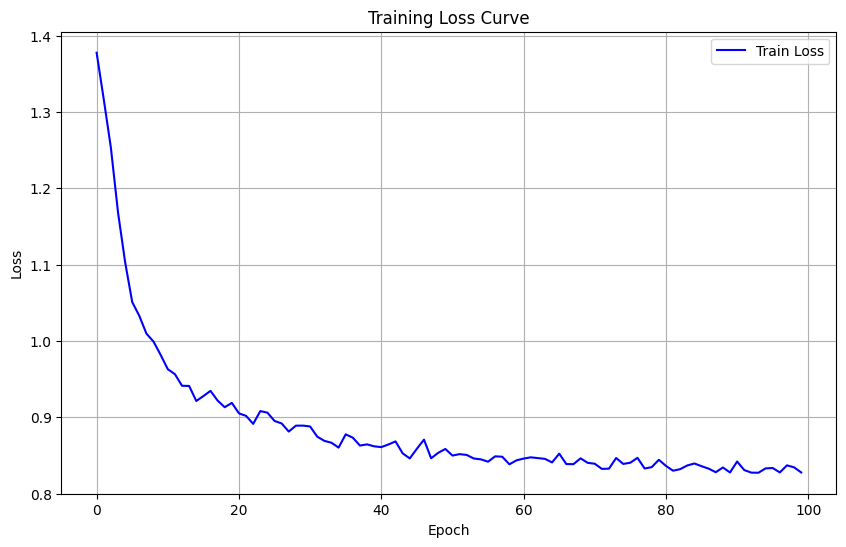

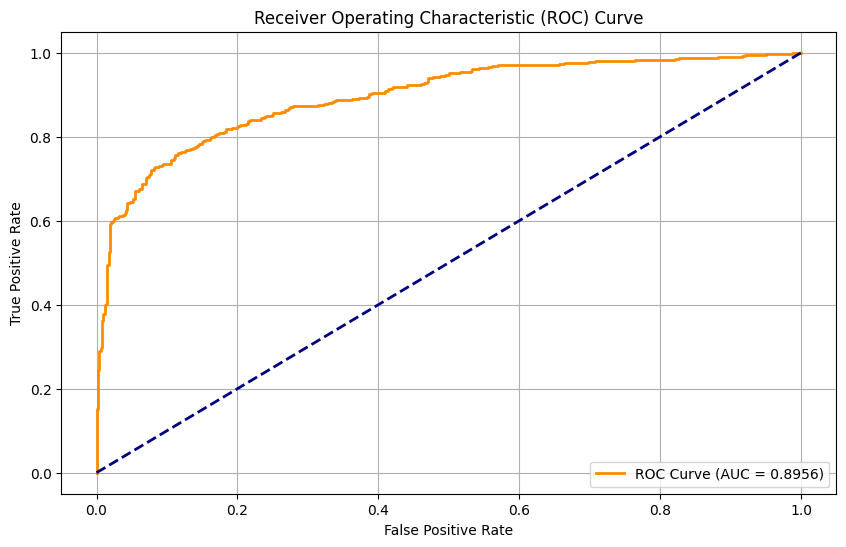

,Node 1,Node 2,Prediction
0,1183,1824,0.958156
1,1151,2570,0.737648
2,1581,1819,0.678937
3,1396,2394,0.975257
4,805,2236,0.818624


In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges, negative_sampling, to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# 1. Load dataset (Cora)
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# 2. Split data for link prediction
data = train_test_split_edges(data)

# 3. Define the GCN Model
class GCNLinkPrediction(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNLinkPrediction, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        return torch.sigmoid((z[edge_index[0]] * z[edge_index[1]]).sum(dim=1))

# 4. Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNLinkPrediction(dataset.num_features, 16, 16).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 5. Train the model
train_losses = []

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    pos_loss = -torch.log(model.decode(z, data.train_pos_edge_index) + 1e-15).mean()
    
    # Generate negative edges
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1)
    )

    neg_loss = -torch.log(1 - model.decode(z, neg_edge_index) + 1e-15).mean()
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    return loss

# 6. Evaluate the model
def test():
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)
    pos_y = z[data.test_pos_edge_index[0]] * z[data.test_pos_edge_index[1]]
    neg_y = z[data.test_neg_edge_index[0]] * z[data.test_neg_edge_index[1]]
    pos_pred = torch.sigmoid(pos_y.sum(dim=1))
    neg_pred = torch.sigmoid(neg_y.sum(dim=1))
    
    y_true = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))])
    y_pred = torch.cat([pos_pred, neg_pred])
    y_pred_label = (y_pred > 0.5).float()

    acc = accuracy_score(y_true, y_pred_label)
    precision = precision_score(y_true, y_pred_label)
    recall = recall_score(y_true, y_pred_label)
    f1 = f1_score(y_true, y_pred_label)
    
    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    return acc, precision, recall, f1, fpr, tpr, roc_auc, pos_pred, neg_pred

# 7. Run training and testing
for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0:
        acc, precision, recall, f1, fpr, tpr, roc_auc, pos_pred, neg_pred = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}')

# 8. Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid()
plt.show()

# 9. Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 10. Create a DataFrame with predictions
test_edges = data.test_pos_edge_index.cpu().numpy().T
pred_df = pd.DataFrame({
    'Node 1': test_edges[:, 0],
    'Node 2': test_edges[:, 1],
    'Prediction': pos_pred.cpu().detach().numpy()
})

pred_df.head()


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 010, Loss: 1.1827, Acc: 0.6490, Precision: 0.5905, Recall: 0.9715, F1: 0.7346
Epoch: 020, Loss: 1.0186, Acc: 0.7381, Precision: 0.6717, Recall: 0.9317, F1: 0.7806
Epoch: 030, Loss: 0.9859, Acc: 0.7495, Precision: 0.6814, Recall: 0.9374, F1: 0.7891
Epoch: 040, Loss: 0.9689, Acc: 0.7429, Precision: 0.6773, Recall: 0.9279, F1: 0.7830
Epoch: 050, Loss: 0.9529, Acc: 0.7429, Precision: 0.6793, Recall: 0.9203, F1: 0.7816
Epoch: 060, Loss: 0.9293, Acc: 0.7429, Precision: 0.6783, Recall: 0.9241, F1: 0.7823
Epoch: 070, Loss: 0.9165, Acc: 0.7486, Precision: 0.6819, Recall: 0.9317, F1: 0.7875
Epoch: 080, Loss: 0.8967, Acc: 0.7562, Precision: 0.6880, Recall: 0.9374, F1: 0.7936
Epoch: 090, Loss: 0.8855, Acc: 0.7600, Precision: 0.6898, Recall: 0.9450, F1: 0.7974
Epoch: 100, Loss: 0.8737, Acc: 0.7647, Precision: 0.6951, Recall: 0.9431, F1: 0.8003


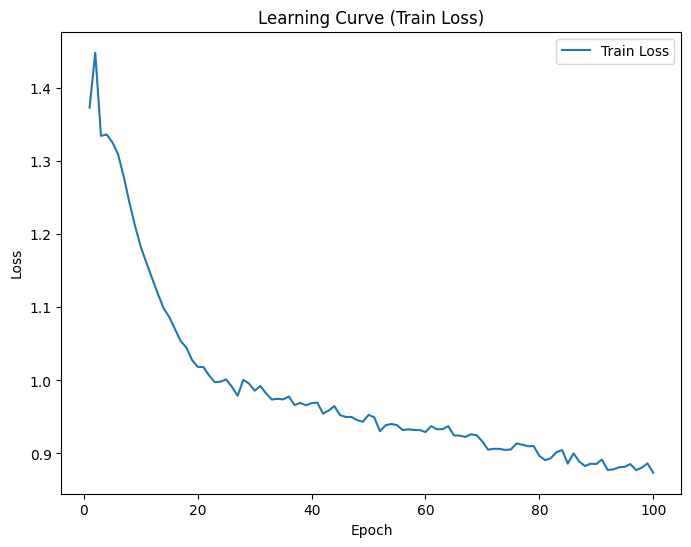

Final Test Results: Acc: 0.7647, Precision: 0.6951, Recall: 0.9431, F1: 0.8003


In [16]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges, negative_sampling, to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# 1. Load dataset (Cora)
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# 2. Split data for link prediction
data = train_test_split_edges(data)

# 3. Define the GCN Model
class GCNLinkPrediction(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNLinkPrediction, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        return torch.sigmoid((z[edge_index[0]] * z[edge_index[1]]).sum(dim=1))

# 4. Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNLinkPrediction(dataset.num_features, 16, 16).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 5. Train the model
train_losses = []

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    pos_loss = -torch.log(model.decode(z, data.train_pos_edge_index) + 1e-15).mean()
    
    # Generate negative edges
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1)
    )

    neg_loss = -torch.log(1 - model.decode(z, neg_edge_index) + 1e-15).mean()
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    return loss

# 6. Evaluate the model
def test():
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)
    pos_y = z[data.test_pos_edge_index[0]] * z[data.test_pos_edge_index[1]]
    neg_y = z[data.test_neg_edge_index[0]] * z[data.test_neg_edge_index[1]]
    pos_pred = torch.sigmoid(pos_y.sum(dim=1))
    neg_pred = torch.sigmoid(neg_y.sum(dim=1))
    
    y_true = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))])
    y_pred = torch.cat([pos_pred, neg_pred])
    y_pred_label = (y_pred > 0.5).float()

    acc = accuracy_score(y_true, y_pred_label)
    precision = precision_score(y_true, y_pred_label)
    recall = recall_score(y_true, y_pred_label)
    f1 = f1_score(y_true, y_pred_label)
    
    return acc, precision, recall, f1, pos_pred, neg_pred, y_true, y_pred_label

# 7. Train and test the model
for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0:
        acc, precision, recall, f1, pos_pred, neg_pred, y_true, y_pred_label = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

# 8. Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 101), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve (Train Loss)')
plt.legend()
plt.show()

# 9. Final Evaluation on Test Set
acc, precision, recall, f1, pos_pred, neg_pred, y_true, y_pred_label = test()
print(f'Final Test Results: Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

In [19]:
# 10. Create DataFrame for link prediction results

df = pd.DataFrame({
    'Edge': list(zip(data.test_pos_edge_index[0].cpu().numpy(), data.test_pos_edge_index[1].cpu().numpy())) + 
            list(zip(data.test_neg_edge_index[0].cpu().numpy(), data.test_neg_edge_index[1].cpu().numpy())),
    'True Label': [1] * len(pos_pred) + [0] * len(neg_pred),
    'Predicted Score': torch.cat([pos_pred, neg_pred]).cpu().numpy(),
    'Predicted Label': y_pred_label.cpu().numpy()
})

df


,Edge,True Label,Predicted Score,Predicted Label
0,"(626, 2558)",1,0.700873,1.0
1,"(650, 1756)",1,0.915672,1.0
2,"(397, 1096)",1,0.427287,0.0
3,"(2127, 2130)",1,0.670069,1.0
4,"(1015, 1143)",1,0.960403,1.0
...,...,...,...,...
1049,"(636, 1106)",0,0.512511,1.0
1050,"(234, 773)",0,0.784916,1.0
1051,"(1687, 2296)",0,0.437915,0.0
1052,"(695, 1659)",0,0.408636,0.0
